In [121]:
import pandas as pd
import numpy as np
import sklearn
import warnings
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_bw

# Dependencies
You probably already have pandas, numpy and sklearn on your machine, and the warnings package should be built in.

Install plotnine using either  

Pip
```
$ pip install plotnine
```
Conda
```
$ conda install -c conda-forge plotnine
```

# Introduction
## The Data
This Dataset includes 1028 instances of all official Pokémon and their special variations and forms. It is up to date as of May 2020. The dataset was originally found on [Kaggle](https://www.kaggle.com/). Its contents were web scraped from [Pokemondb](https://pokemondb.net/) and [Serebii](https://serebii.net/). There was some information missing from the dataset, which I manually filled in by referencing [Bulbapedia](https://bulbapedia.bulbagarden.net/wiki/Main_Page). All of these websites are online Pokémon databases.

There are 50 different columns in this dataset. Descriptions for all of the variables can be found on the dataset's [Kaggle page](https://www.kaggle.com/mariotormo/complete-pokemon-dataset-updated-090420).


In [122]:
df = pd.read_csv("https://raw.githubusercontent.com/Dst017/Tutorial/main/pokedex_fixed.csv")
df.head()

,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,type_2,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
0,1,Bulbasaur,Bisasam,フシギダネ (Fushigidane),1,Normal,Seed Pokémon,2,Grass,Poison,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,2,Ivysaur,Bisaknosp,フシギソウ (Fushigisou),1,Normal,Seed Pokémon,2,Grass,Poison,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,3,Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,Poison,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
3,3,Mega Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,Poison,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
4,4,Charmander,Glumanda,ヒトカゲ (Hitokage),1,Normal,Lizard Pokémon,1,Fire,NaN,...,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5


## The Goal
Every Pokémon has a main type and possibly a secondary type. Types play a large part in setting a theme for each Pokémon and often determine what kinds of moves and abilities a Pokémon can posses. Types are generally but not necessarily elemental in nature. Some example types are grass, water, steel, dragon, and fairy. The goal is to predict a Pokémon’s main type.

## Things to Know
There are a number of points in this tutorial where randomness is introduced, specifically in the shuffling of the dataset and model building. As such, running cells multiple times will produce different results each time. However, don't worry! The variation in end results shouldn't differ too much.

In addition, code in the Hyperparameter Tuning section may take some time to run. This is because many different models are being trained in succession. Look at the output from the print statements to check on the progress of the training.

# Data Cleaning
## Removing Bad Rows
There are two Pokémon forms in the dataset that are missing some information due to there being no actual known values for certain variables. These two Pokémon are Eternatus Eternamax and Darmanitan Galarian Zen Mode. Let's remove them from the dataframe.

In [123]:
bad_mon1 = np.where(df["name"] == "Darmanitan Galarian Zen Mode")[0][0]
bad_mon2 = np.where(df["name"] == "Eternatus Eternamax")[0][0]

df = df.drop([bad_mon1, bad_mon2])

## Removing Unnecessary Columns
We have gotten a nice overview of the data, but due to the number of columns in the dataframe, we are unable to see all of the data. To help us better understand the data we are working with, let's view all of the dataframe's column names.

In [124]:
df.columns

Index(['pokedex_number', 'name', 'german_name', 'japanese_name', 'generation',
       'status', 'species', 'type_number', 'type_1', 'type_2', 'height_m',
       'weight_kg', 'abilities_number', 'ability_1', 'ability_2',
       'ability_hidden', 'total_points', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'catch_rate', 'base_friendship',
       'base_experience', 'growth_rate', 'egg_type_number', 'egg_type_1',
       'egg_type_2', 'percentage_male', 'egg_cycles', 'against_normal',
       'against_fire', 'against_water', 'against_electric', 'against_grass',
       'against_ice', 'against_fight', 'against_poison', 'against_ground',
       'against_flying', 'against_psychic', 'against_bug', 'against_rock',
       'against_ghost', 'against_dragon', 'against_dark', 'against_steel',
       'against_fairy'],
      dtype='object')

There are a lot of different variables here, but only some of them are even potentially useful for us. Every Pokémon has a unique name and pokedex number (ignoring special forms), so neither the name variables nor the pokedex number will be helpful. Furthermore, the variables indicating type advantage/disadvantage are merely a mapping of the type 1 (what we are trying to predict) and type 2 variables. It would be unnecessary to try and predict Pokémon types if we already knew what types they were effective against.

It is also worthwhile noting that some of our categorical variables simply have too many levels (categories) to be useful especially considering that there are only 1026 instances in our dataset.

In [125]:
print(len(df["species"].unique()))
print(len(df["ability_1"].unique()))
print(len(df["ability_2"].unique()))
print(len(df["ability_hidden"].unique()))

641
203
127
155


A possible way to deal with this issue is to group some of the levels together so that there are fewer overall categories, but for simplicity, we will drop these variables.

We now subset the dataframe so that it only includes relevant columns. Note that the name column has been left in for now as a way to identify data points.

In [126]:
start_index1 = np.where(df.columns == "type_number")[0][0]
end_index1 = np.where(df.columns == "abilities_number")[0][0]

start_index2 = np.where(df.columns == "total_points")[0][0]
end_index2 = np.where(df.columns == "egg_cycles")[0][0]

# column indices 1, 4, and 5 correspond to the name, generation, and status variables respectively
col_indices = [1, 4, 5] + list(range(start_index1, end_index1 + 1)) + list(range(start_index2, end_index2 + 1))
df = df.iloc[:, col_indices]

## Dealing with Missing Values
Missing values are troublesome in that they can lead you toward incorrect conclusions. Furthermore, many machine learning algorithms are unable to elegantly deal with missing values. Let's check to see which of our variables contain missing values.

In [127]:
for col in df.columns:
    if (df[col].isnull().values.any()): print(col)

type_2
catch_rate
egg_type_1
egg_type_2
percentage_male


It makes sense that these variables contain missing values. Some Pokémon only have one type. Others cannot actually be caught in the game. As for the egg types, many Pokémon cannot breed and thus do not have egg forms. Finally, not all Pokémon have genders. Let's replace all the NaN's for the categorical variables to "None" and the NaN's for catch rate to be -1000, an extremely low value to indicate the inability to catch.

In [128]:
# for categorical
for col in ["type_2", "egg_type_1", "egg_type_2"]:
    df[col] = df[col].fillna("None")
    
# for catch rate
df["catch_rate"] = df["catch_rate"].fillna(-1000)

Note that we have not dealt with the missing values for the percentage male variable. We will get back to this later.

# Feature Engineering
## Pokémon Growth Rate
An indicator of a Pokémon's strength is its level, and Pokémon require experience to level up. The growth rate of a Pokémon is a summary of its level to cumulative experience curve. There are six different growth rates a Pokémon can have: fluctuating, slow, medium slow, medium fast, fast, and erratic. Growth rate is currently being treated as an unordered categorical variable, but there is actually somewhat of an ordering in terms of required experience to different levels.

A seemingly simple way to capture this ordering would be to convert the levels of growth rate to numeric such that fluctuating = 0, slow = 1, medium slow = 2, medium fast = 3, fast = 4, and erratic = 5. After all, this is the correct order of growth rates in terms of getting to level 100 (the max level for Pokémon). However, the order of growth rates in terms of getting to level 100 does not necessarily hold across all levels. For example, until level 23, fluctuating—the slowest growth rate for getting to level 100—actually requires the least total amount of experience (except at level 11 being beaten out slightly by medium slow). As a matter of fact, fluctuating does not even become the slowest growth rate until it is finally surpassed by slow at level 62.

To better capture the somewhat inconsistent ordering or the growth rates, let's create two more variables: the cummulative required experience to get to level 50 and to level 100. Levels 50 and 100 were chosen as they are generally regarded as the most important levels in a Pokémon's growth. Furthermore, cummulative required experience is a better choice than simply using 0 - 5 integer scale as it captures the relative difference between levels.

Let's create a function to handle the mappings of growth rate experience and apply the said function to create new columns for the two levels.

In [129]:
def GrowthToExp(growth_rate, level):
    lvl50 = {"Fluctuating":142500, "Slow":156250, "Medium Slow":117360, 
             "Medium Fast":125000, "Fast":100000, "Erratic":125000}
    lvl100 = {"Fluctuating":1640000, "Slow":1250000, "Medium Slow":1059860, 
             "Medium Fast":1000000, "Fast":800000, "Erratic":600000}
    if (level == 50): return lvl50[growth_rate]
    return lvl100[growth_rate]

df["exp_50"] = df["growth_rate"].map(lambda x: GrowthToExp(x, 50))
df["exp_100"] = df["growth_rate"].map(lambda x: GrowthToExp(x, 100))

We can see that the mappings and new column creations were successful based on an arbitrary group of Pokémon known to have different growth rates.

In [130]:
# names of six Pokémon with different growth rates
diff_growths = ["Bulbasaur", "Butterfree", "Shroomish", "Growlithe", "Shedinja", "Lunatone"]

df.loc[df["name"].isin(diff_growths), ["name", "growth_rate", "exp_50", "exp_100"]]

,name,growth_rate,exp_50,exp_100
0,Bulbasaur,Medium Slow,117360,1059860
15,Butterfree,Medium Fast,125000,1000000
76,Growlithe,Slow,156250,1250000
338,Shroomish,Fluctuating,142500,1640000
345,Shedinja,Erratic,125000,600000
398,Lunatone,Fast,100000,800000


## Pokémon Gender
Pokémon can either be male or female, but a handfull of Pokémon are also genderless. This leads to a bit of an issue regarding the percentage male variable in our dataset. Percentage male indicates what percent of all of a certain kind of Pokémon is male, but what should this value be for Pokémon without a gender. It may make sense to assign a value of 0 to this for genderless Pokémon; after all, if a Pokémon has no gender then none of its kind is male. However, this value of 0 overlaps with all the Pokémon that do have a gender but are only ever female.

To combat this, let's define a new colum with a binary variable indicating whether or not a Pokémon is genderless.

In [131]:
df["has_gender"] = df["percentage_male"].map(lambda x: False if pd.isna(x) else True)

We can once again use an arbitrary group of Pokémon which are known to have different gender percentages to illustrate the success of the above change.

In [132]:
# names of Pokémon with different gender percentages
diff_genders = ["Nidoking", "Nidoqueen", "Bulbasaur", "Caterpie", "Mew"]

df.loc[df["name"].isin(diff_genders), ["name", "percentage_male", "has_gender"]]

,name,percentage_male,has_gender
0,Bulbasaur,87.5,True
13,Caterpie,50.0,True
42,Nidoqueen,0.0,True
45,Nidoking,100.0,True
191,Mew,NaN,False


Finally, we edit the existing percentage male column so that NaN's no longer exist and take out the name column as it is no longer required for viewing purposes.

In [133]:
df["percentage_male"] = df["percentage_male"].fillna(0)
df = df.drop("name", axis = 1)

## One-Hot Encoding
Many of Scikit-learn's machine learning algorithms (particularly the ones in this tutorial) are unable to take in categorical data that are represented as strings. The only way around this is to change all categories' values from string to numeric.

A simple form of this is known as label encoding. Assign a different integer for each level within a variable. For variables that are intrinsically ordered this works well, but for those that are unordered, assuming a natural ordering can lead to poor performance or unexpected results. This is where one-hot encoding comes in.

One-hot encoding splits a single variable into n different binary variables with n being the number of levels of the original variable. Each of these n new variables corresponds to a specific level of the original variable and is 1 when an instance is in that category and 0 otherwise.

Here is a toy dataframe. Assume that all possible levels for each categorical variable are in the dataframe.

In [134]:
toy_df = pd.DataFrame({"name":["Bulbasaur", "Charmander", "Mewtwo"],
                       "type_1":["Grass", "Fire", "Psychic"],
                       "growth_rate":["Medium Slow", "Medium Slow", "Slow"],
                       "height_m":[.7, .6, 2]})

toy_df

,name,type_1,growth_rate,height_m
0,Bulbasaur,Grass,Medium Slow,0.7
1,Charmander,Fire,Medium Slow,0.6
2,Mewtwo,Psychic,Slow,2.0


Here is the toy dataframe with one-hot encoding applied to type 1 and growth rate.

In [135]:
enc_toy_df = pd.DataFrame({"name":["Bulbasaur", "Charmander", "Mewtwo"],
                           "type_1_Grass":[1, 0, 0],
                           "type_1_Fire":[0, 1, 0],
                           "type_1_Psychic":[0, 0, 1],
                           "growth_rate_Medium_Slow":[1, 1, 0],
                           "growth_rate_Slow":[0, 0, 1],
                           "height_m":[.7, .6, 2]})
enc_toy_df

,name,type_1_Grass,type_1_Fire,type_1_Psychic,growth_rate_Medium_Slow,growth_rate_Slow,height_m
0,Bulbasaur,1,0,0,1,0,0.7
1,Charmander,0,1,0,1,0,0.6
2,Mewtwo,0,0,1,0,1,2.0


The two categorical variables type 1 and growth rate turned into $3 \text{ (levels for type 1) } + 2 \text{ (levels for growth rate) } = 5$ variables. As such, the downside of using one-hot encoding is that it greatly increases complexity and run time.

Let's now apply one-hot encoding to our main dataframe. Note that we don't need to do this for our response variable (type 1).

In [136]:
enc_feats_df = pd.get_dummies(df.loc[:, df.columns != "type_1"])
enc_df = pd.concat([df["type_1"], enc_feats_df], axis = 1)

print(df.shape)
print(enc_df.shape)

(1026, 27)
(1026, 79)


We see that our dataframe has almost tripled in size from a $1026 \times 27$ to a $1026 \times 79$.

# Model Creation
## Data Preparation

It is almost time to build our models, but we must first split our data into a training and test set. To eliminate bias due to the ordering of our dataset, we also shuffle our dataset.

In [137]:
rand_df = sklearn.utils.shuffle(enc_df)

# 80/20 train/test split
break_index = rand_df.shape[0]//5
test_df = rand_df.iloc[:break_index + 1, :]
train_df = rand_df.iloc[break_index + 1:, :]

Scikit-learn machine learning classifiers take in numpy arrays rather than dataframes. We also separate our response column from our feature columns to ensure that we are not training on what we are attempting to predict.

In [138]:
train_X = train_df.loc[:, train_df.columns != "type_1"].to_numpy()
train_y = train_df["type_1"].to_numpy()

test_X = test_df.loc[:, test_df.columns != "type_1"].to_numpy()
test_y = test_df["type_1"].to_numpy()

## Decision Tree
Decision trees are commonly used for predictive modelling and classification. As the name suggests, they work like trees starting from a root and branching off to different nodes based on variables that best split the data. In scikit-learn's decision tree classifier, the default splitting criteron is Gini impurity.

Gini impurity measures how often a randomly chosen element would be labeled incorrectly should its labeling be picked based on the its sample distribution. For a set that has $J$ classes and probability of chossing class $i$ being $p_i$, it can be calulated as:
$$I_G(p) = 1 - \sum_{i = 1}^J (p_i)^2$$
Nodes with minimum Gini impurity are chosen.

In [139]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier()
preds = tree_model.fit(train_X, train_y).predict(test_X)

tree_acc = np.mean(preds == test_y)

print("test accuracy: %f" %tree_acc)

test accuracy: 0.533981


After training the model and comparing its predictions on the test set to the labels of the test set, we see an accuracy of around .5. Perhpas we can improve this metric by choosing a different classification method.

## Random Forests
Random forests is a step up from the basic decision tree algorithm in that it is a tree ensemble learning method. It creates a group or "forest" of decision trees and outputs the mode of the responses from the group of decision trees. The "random" part of random forests comes about in that each tree only uses a randon subset of the data's features.

Like the decision tree classifier, scikit-learn's random forest classifier uses Gini impurity as the default splitting criterion.

In [140]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(random_state = 17)
preds = forest_model.fit(train_X, train_y).predict(test_X)

forest_acc1 = np.mean(preds == test_y)

print("test accuracy: %f" %forest_acc1)

test accuracy: 0.626214


## Hyperparameter Tuning
By using random forests, we were able to improve accuracy from around .5 to around .6. This is a significant improvement in performance, but we may be able to squeeze a bit more juice out by working with our random forests classifier's parameters.

So far, we have used the default parameters provided by scikit-lern. In order to optimize our performance, we can adjust some of our hyperparametrs and see if this results in an improvement in accuracy. For simplicity, let's choose two hyperparameters to work on: n_estimators and max_features. The n_estimators parameter determines how many trees are in the forest, and max_features decides how many features to consider when looking for the best split.

To optimize our model, we can try combinations of different values for n_estimators and max_features. The default value of n_estimators is 100, and the default value for max_features is "auto" (square root of the number of features). For n_estimators let's create a range from 50 - 500 with breaks every 50 steps. As for max_features, let's choose from "auto," "log2," and None (in None max_features = number of features).

In [141]:
n_ests = list(range(50, 550, 50))
max_feats = ["auto", "log2", None]

# tuples of parameters for convenience
pairs = [(n_est, max_feat) for n_est in n_ests for max_feat in max_feats]

We now train random forests classifiers so that every combination of n_estimators and max_features from our range is covered. We also use k-fold cross validation to help measure the proficiency of our models. In summary, k-fold cv works by partitioning our training data into k different groups (folds). The model is then trained using the data from k - 1 of the folds as training data and the other fold as a validation set to assess performance. This is done k times so that every fold is used as the validation set once. A summary statistic of our model's performance is now simply the average of our k different performance metrics.

In [142]:
from sklearn.model_selection import KFold

# we arbitraily to split our data into 5 folds
folds = KFold(n_splits = 5)

# mean accuracies for each combination of hyperparameters
mean_accs = []
for pair in pairs:
    print("Training with n_estimators = %d, max_features = %s" %pair)
    model = RandomForestClassifier(n_estimators = pair[0], max_features = pair[1], random_state = 17)
    
    # k accuracies each based on evaluation over a fold
    accs = []
    # folds.split returns a generator of tuples (list1, list2)
    # where list1 contains all indices in k - 1 folds and list2 the others
    for train_indices, val_indices in folds.split(train_df):
        train_feats = train_X[train_indices, :]
        train_labels = train_y[train_indices]
        
        val_feats = train_X[val_indices, :]
        val_labels = train_y[val_indices]
        
        preds = model.fit(train_feats, train_labels).predict(val_feats)
        
        acc = np.mean(preds == val_labels)
        
        accs.append(acc)
        
    mean_accs.append(np.mean(accs))

Training with n_estimators = 50, max_features = auto
Training with n_estimators = 50, max_features = log2
Training with n_estimators = 50, max_features = None
Training with n_estimators = 100, max_features = auto
Training with n_estimators = 100, max_features = log2
Training with n_estimators = 100, max_features = None
Training with n_estimators = 150, max_features = auto
Training with n_estimators = 150, max_features = log2
Training with n_estimators = 150, max_features = None
Training with n_estimators = 200, max_features = auto
Training with n_estimators = 200, max_features = log2
Training with n_estimators = 200, max_features = None
Training with n_estimators = 250, max_features = auto
Training with n_estimators = 250, max_features = log2
Training with n_estimators = 250, max_features = None
Training with n_estimators = 300, max_features = auto
Training with n_estimators = 300, max_features = log2
Training with n_estimators = 300, max_features = None
Training with n_estimators = 35

Note that we are still doing all of our training on our original training set and merely evaluating performance on a subset of our original training set. The test set is not used to make decisions on training our model.

### Visualizing Hyperparameter Effectiveness

Let's now visually explore how our using different hyperparameters affect accuracy. We first put all of our mean accuracies into a dataframe with their associated hyperparameters as columns as well. This organization allows us to easily plot our results.

In [143]:
acc_df = pd.DataFrame({"mean_accuracy":mean_accs, 
                       "n_ests":np.repeat(n_ests, len(max_feats)), 
                       "max_feature":len(n_ests)*max_feats})
acc_df.head()

,mean_accuracy,n_ests,max_feature
0,0.587805,50,auto
1,0.598780,50,log2
2,0.578049,50,None
3,0.604878,100,auto
4,0.598780,100,log2


For plotting, we use the popular `R` package, ggplot, which happens to also now be in Python!

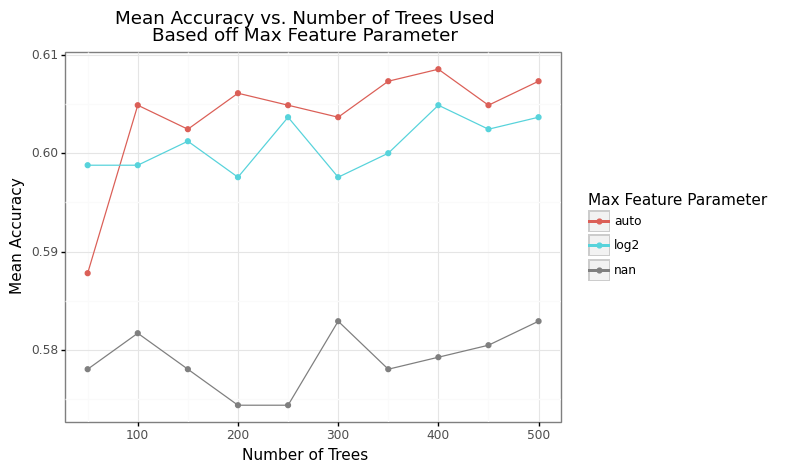

<ggplot: (8771428200777)>

In [144]:
(
    ggplot(acc_df, aes(x = "n_ests", y = "mean_accuracy", color = "max_feature")) 
        + geom_line() + geom_point() 
        + labs(x = "Number of Trees", y = "Mean Accuracy", 
               title = "Mean Accuracy vs. Number of Trees Used\nBased off Max Feature Parameter",
               color = "Max Feature Parameter")
        + theme_bw()
)

For our final model, we will pick the pair of hyperparameters that maximize mean accuracy according to our plot.

In [145]:
max_index = np.argmax(mean_accs)
best_pair = pairs[max_index]
print("best hyperparameter combination:", best_pair)

best hyperparameter combination: (400, 'auto')


In [146]:
model = RandomForestClassifier(n_estimators = best_pair[0], max_features = best_pair[1], random_state = 17)
preds = model.fit(train_X, train_y).predict(test_X)

forest_acc2 = np.mean(preds == test_y)
print("Difference in accuracy evaluated on test set: %f" %(forest_acc2 - forest_acc1))

Difference in accuracy evaluated on test set: 0.029126


## Results

In [147]:
print("Decision Tree Test Accuracy: %f" %tree_acc)
print("Random Forests Accuracy (default parameters): %f" %forest_acc1)
print("Random Forests Accuracy (optimized parameters): %f" %forest_acc2)

Decision Tree Test Accuracy: 0.533981
Random Forests Accuracy (default parameters): 0.626214
Random Forests Accuracy (optimized parameters): 0.655340


You should be able to see a significant improvement from the decision tree model to the random forests models. When I last ran this notebook, I also saw an improvement of about 3\% from the first random forests model to the second. Of course, due to the many random elements within this tutorial, results may vary. It is not guaranteed that our best choice of hyperparameters will result in a better accuracy than what our default random forest model gave, but we definitely expect them to.

# Additional Resources
* [One-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) - simple article on the motivation behind and how one hot encoding works
* [Decision Trees](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052) - how decision trees work
* [Random Forests](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#intro) - a page all about random forests made by the inventors of the algorithm itself
* [K-fold Cross Validation](https://machinelearningmastery.com/k-fold-cross-validation/) - overview of k-fold cross validation

I want to include a picture to end this tutorial, but since I'm unsure about the use of outside images...

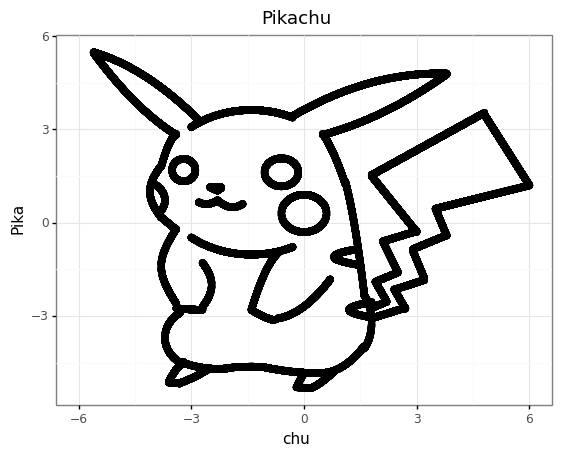

<ggplot: (8771408846568)>

In [148]:
'''
Ignore the code in this cell!!!
But please run it!
Don't worry I hand typed the csv's that are read in here,
so the code and data here were all made by me
though I will admit that I ripped the coefficients for these functions
from here https://www.desmos.com/calculator/oaer3zh6jo
'''

def line(x, tup):
    x = x[x >= tup[3]]
    x = x[x <= tup[4]]
    y = (tup[2] - tup[0]*x)/tup[1]
    
    return list(zip(x, y))

def elipse(x, tup):
    x = x[x >= -3]
    x = x[x <= -.3]
    y = -(tup[0]*((tup[1]*(tup[2]*(x**2) + tup[3]*x + tup[4]))**.5) - tup[5])/tup[6]
    y1 = (tup[0]*((tup[1]*(tup[2]*(x**2) + tup[3]*x + tup[4]))**.5) + tup[5])/tup[6]
    
    return list(zip(x, y)) + list(zip(x, y1))

def parabola(x, tup):
    x = x[x >= tup[3]]
    x = x[x <= tup[4]]
    y = tup[0]*((x + tup[1])**2) + tup[2]
    
    return list(zip(x, y))

def hyperbola(x, tup):
    x = x[x >= tup[4]]
    x = x[x <= tup[5]]
    y = (tup[3]*((x**2 + 2*tup[0]*x + tup[0]**2 - tup[1]**2)**.5) - tup[1]*tup[2])/tup[1]
    y1 = -(tup[3]*((x**2 + 2*tup[0]*x + tup[0]**2 - tup[1]**2)**.5) + tup[1]*tup[2])/tup[1]
    
    return list(zip(x, y)) + list(zip(x, y1))

def circle(x, tup):
    x = x[x >= tup[4]]
    x = x[x <= tup[5]]
    y = tup[3]*((-x**2 - 2*tup[0]*x - tup[0]**2 + tup[1]**2)**.5 - tup[1]*tup[2])/tup[1]
    y1 = -tup[3]*((-x**2 - 2*tup[0]*x - tup[0]**2 + tup[1]**2)**.5 + tup[1]*tup[2])/tup[1]
    
    return list(zip(x, y)) + list(zip(x, y1))

def weird(x, tup):
    x = x[x >= -1.1]
    x = x[x <= .6]
    y = (tup[0]*((tup[1]*(tup[2]*x**2 + tup[3]*x + tup[4]))**.5) + tup[5])/tup[6]
    
    return list(zip(x, y))

x = np.linspace(-6, 6, 20000)

pika_points = []

line_coeff = pd.read_csv("https://raw.githubusercontent.com/Dst017/Tutorial/main/line_coeff.csv", header = None)
pika_points.append(line_coeff.apply(lambda row: line(x, tuple(row)), axis = 1))

elipse_coeff = pd.read_csv("https://raw.githubusercontent.com/Dst017/Tutorial/main/elipse_coeff.csv", header = None)
pika_points.append(elipse_coeff.apply(lambda row: elipse(x, tuple(row)), axis = 1))

parabola_coeff = pd.read_csv("https://raw.githubusercontent.com/Dst017/Tutorial/main/parabola_coeff.csv", header = None)
pika_points.append(parabola_coeff.apply(lambda row: parabola(x, tuple(row)), axis = 1))

hyperbola_coeff = pd.read_csv("https://raw.githubusercontent.com/Dst017/Tutorial/main/hyperbola_coeff.csv", header = None)
pika_points.append(hyperbola_coeff.apply(lambda row: hyperbola(x, tuple(row)), axis = 1))

circle_coeff = pd.read_csv("https://raw.githubusercontent.com/Dst017/Tutorial/main/circle_coeff.csv", header = None)
pika_points.append(circle_coeff.apply(lambda row: circle(x, tuple(row)), axis = 1))

weird_coeff = pd.read_csv("https://raw.githubusercontent.com/Dst017/Tutorial/main/weird_coeff.csv", header = None)
pika_points.append(weird_coeff.apply(lambda row: weird(x, tuple(row)), axis = 1))

pika_points = [e for srs in pika_points for lst in srs for e in lst]

pika_df = pd.DataFrame(pika_points, columns = ["x", "y"])

warnings.filterwarnings('ignore')

(
    ggplot(pika_df, aes(x = "x", y = "y")) 
        + geom_point(size = 2) 
        + labs(x = "chu", y = "Pika", title = "Pikachu")
        + theme_bw()
)